### Classically estimate expectation values of quantum systems

In this tutorial, we will:
- Create a quantum circuit, $U$, which implements a Trotterized 1D Ising spin chain on 10 qubits
- Specify an observable, $O=\frac{1}{N}\sum_iz_i$, to calculate the average magnetization for each site, $i$, in the spin chain after 20 Trotter steps
- Separate $U$ into Clifford and non-Clifford parts, $C$ and $P$ respectively, such that $U = PC$. In other words, evolve the Clifford part of $U$ to the front of the circuit.
- Approximately propagate $O$ through $P$, resulting in a new operator, $\tilde{O}_P=P^{\dagger}OP$
- Evolve $\tilde{O}_P$ by $C$, resulting in a new operator $\tilde{O}=C^{\dagger}\tilde{O}_PC$
- Calculate average magnetization $\langle0|\tilde{O}|0\rangle\approx\langle0|U^{\dagger}OU|0\rangle$
    - Show that increasing the number of terms kept in $\tilde{O}$ results in more accurate expectation values

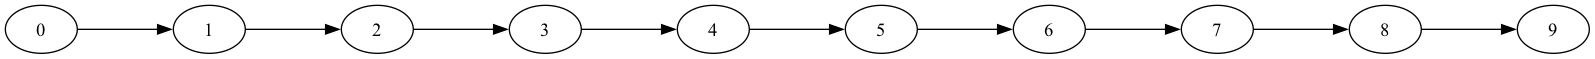

In [1]:
from qiskit.transpiler import CouplingMap
from rustworkx.visualization import graphviz_draw

num_qubits = 10

coupling_map = CouplingMap.from_line(num_qubits, bidirectional=False)
graphviz_draw(coupling_map.graph, method="circo")

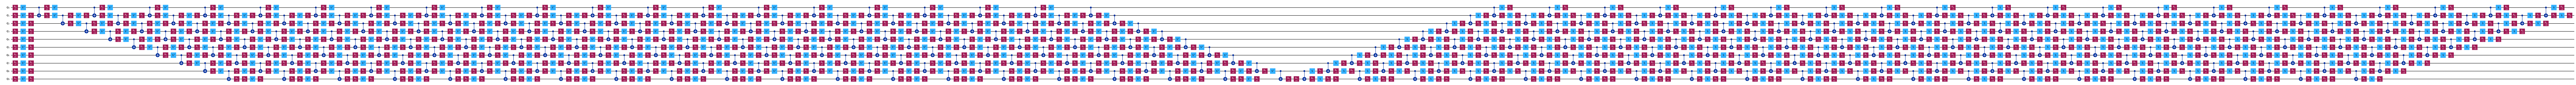

In [2]:
import numpy as np
from qiskit import QuantumCircuit

# Num Trotter steps
num_steps = 20
theta_rx = np.pi / 6

# Create Trotter circuits with varying global fields
circuit = QuantumCircuit(num_qubits)
edges = coupling_map.get_edges()
for _ in range(num_steps):
    circuit.rx(theta_rx, [i for i in range(num_qubits)])
    for edge in edges:
        circuit.sdg(edge)
        circuit.ry(np.pi/2, edge[1])
        circuit.cx(edge[0], edge[1])
        circuit.ry(-np.pi/2, edge[1])
circuit = circuit.compose(circuit.inverse())
circuit.draw("mpl", fold=-1)

In [3]:
from qiskit.quantum_info import SparsePauliOp

observable = (
    SparsePauliOp(["I" * iq + "Z" + "I" * (num_qubits - iq - 1) for iq in range(num_qubits)])
    / num_qubits
)
observable

SparsePauliOp(['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ'],
              coeffs=[0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j,
 0.1+0.j, 0.1+0.j])

In [4]:
from pauli_prop import evolve_through_cliffords

cliff, non_cliff = evolve_through_cliffords(circuit)
print(cliff)

Clifford: Stabilizer = ['+IIIIIIIIIZ', '+IIIIIIIIZI', '+IIIIIIIZII', '+IIIIIIZIII', '+IIIIIZIIII', '+IIIIZIIIII', '+IIIZIIIIII', '+IIZIIIIIII', '+IZIIIIIIII', '+ZIIIIIIIII'], Destabilizer = ['+IIIIIIIIIX', '+IIIIIIIIXI', '+IIIIIIIXII', '+IIIIIIXIII', '+IIIIIXIIII', '+IIIIXIIIII', '+IIIXIIIIII', '+IIXIIIIIII', '+IXIIIIIIII', '+XIIIIIIIII']


In [5]:
import time
from pauli_prop import propagate_through_circuit

max_terms_list = [10**i for i in range(7)]
approx_evs = []
durations = []
for max_terms in max_terms_list:
    st = time.time()
    evolved_obs = propagate_through_circuit(observable, non_cliff, max_terms=max_terms, atol=1e-12, frame="h")[0]
    evolved_obs.paulis = evolved_obs.paulis.evolve(cliff, frame="h")
    durations.append(time.time() - st)
    approx_evs.append(float(evolved_obs.coeffs[~evolved_obs.paulis.x.any(axis=1)].sum()))

Text(0.5, 1.0, 'Simulating 20-step 1D Ising Model')

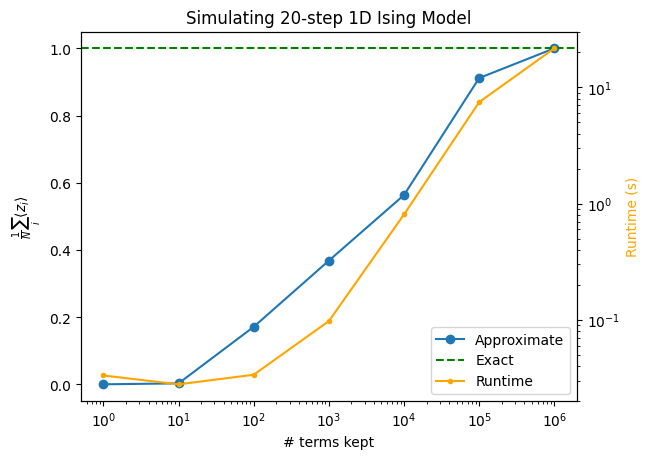

In [6]:
import matplotlib.pyplot as plt

ax1 = plt.gca()
ax1.plot(max_terms_list, approx_evs, marker='o', label="Approximate")
ax1.axhline(1.0, linestyle="--", color="green", label="Exact")
ax1.set_xscale("log")
ax1.set_xlabel("# terms kept")
ax1.set_ylabel(r"$\frac{1}{N} \sum_i \langle z_i \rangle$")

ax2 = ax1.twinx()
ax2.plot(max_terms_list, durations, marker='.', label="Runtime", color="orange")
ax2.set_ylabel("Runtime (s)", color="orange")
ax2.set_yscale("log")

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="lower right")

plt.title(f"Simulating {num_steps}-step 1D Ising Model")